# Library import

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, accuracy_score

import os
import json

# from google.colab import drive # delete this line if not used on colab
# drive.mount("/content/drive", force_remount = True) # delete this line if not used on colab

In [40]:
# data_path = "C:/Users/Walraff/OneDrive - Universite de Liege/Documents/Ulg/Master2/TFE/data"
# data_path = "/content/drive/MyDrive/TFE"
data_path = "/home/jwalraff/TFE/data"
original_df = pd.read_csv(f'{data_path}/final_status_SPARE.csv')
original_df

,ProteinName_SPARE,Peptide_SPARE,Status_SPARE
0,sp|P02751|FINC_HUMAN,VDVIPVNLPGEHGQR,bon
1,sp|P02751|FINC_HUMAN,STTPDITGYR,bon
2,sp|P02751|FINC_HUMAN,SYTITGLQPGTDYK,bon
3,sp|P02751|FINC_HUMAN,IYLYTLNDNAR,bon
4,sp|P04114|APOB_HUMAN,TGISPLALIK,bon
...,...,...,...
150,sp|P02743|SAMP_HUMAN,VGEYSLYIGR,bon
151,sp|P04004|VTNC_HUMAN,GQYCYELDEK,mauvais
152,sp|P04004|VTNC_HUMAN,FEDGVLDPDYPR,bon
153,sp|P04004|VTNC_HUMAN,DWHGVPGQVDAAMAGR,bon


In [41]:
data_human_unique_peptide_path = f'{data_path}/Tryptic unique peptide of the human proteome.csv'
data_human_unique_peptide = pd.read_csv(data_human_unique_peptide_path, delimiter = ";")
data_human_unique_peptide

,Peptide,Protein,Peptide Modified Sequence,Standard Type,First Position,Last Position,Missed Cleavages,Predicted Retention Time,Average Measured Retention Time,Peptide Note
0,MQLVQESEEK,sp|A0A0B4J2F0|PIOS1_HUMAN,MQLVQESEEK,NaN,43,52,0,NaN,NaN,NaN
1,QPCLPIWHEMVETGGSEGVVR,sp|A0A0K2S4Q6|CD3CH_HUMAN,QPC[+57]LPIWHEMVETGGSEGVVR,NaN,59,79,0,NaN,NaN,NaN
2,VPLLLSILGAILWVNRPWR,sp|A0A0K2S4Q6|CD3CH_HUMAN,VPLLLSILGAILWVNRPWR,NaN,177,195,0,NaN,NaN,NaN
3,SHPPPPEK,sp|A0A0U1RRE5|NBDY_HUMAN,SHPPPPEK,NaN,61,68,0,NaN,NaN,NaN
4,SVSLLRPPFSQLPSK,sp|A0A1B0GTW7|CIROP_HUMAN,SVSLLRPPFSQLPSK,NaN,31,45,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
365085,ELNQYFELAK,sp|Q9Y3F1|TA6P_HUMAN,ELNQYFELAK,NaN,44,53,0,NaN,NaN,NaN
365086,GSFLIWLLLCWNSWYHLR,sp|Q9Y6C7|L3R2A_HUMAN,GSFLIWLLLC[+57]WNSWYHLR,NaN,36,53,0,NaN,NaN,NaN
365087,LCHGDSELTSGLLAT,sp|Q9Y6C7|L3R2A_HUMAN,LC[+57]HGDSELTSGLLAT,NaN,80,94,0,NaN,NaN,NaN
365088,SCQIEQVK,sp|Q9Y6Z2|CF123_HUMAN,SC[+57]QIEQVK,NaN,32,39,0,NaN,NaN,NaN


# Dataset, model and loading data

In [ ]:
# Define the vocabulary
amino_acid_vocab = {aa: idx+1 for idx, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}

class PeptideDataset(Dataset):
    def __init__(self, sequences, labels, pseudo_labels, vocab, max_len):
        """
        Dataset for peptide sequences.

        Args:
            sequences (list of str): List of amino acid sequences.
            labels (list of int): List of labels associated with the sequences.
            pseudo_labels (list of int): List of pseudo labels associated with the sequences.
            vocab (dict): Mapping dictionary {amino acid: index}.
            max_len (int): Maximum sequence length (applies padding).
        """
        self.sequences = sequences
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        self.pseudo_labels = pseudo_labels

    def encode_sequence(self, sequence):
        """Encodes a sequence into integer indices with padding."""
        encoded = [self.vocab.get(aa, 0) for aa in sequence]  # Encodage
        encoded += [0] * (self.max_len - len(encoded))  # Padding
        return torch.tensor(encoded, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        """Returns an encoded sequence, its label and the pseudo label."""
        sequence = self.sequences[idx]
        label = self.labels[idx]
        pseudo_label = self.pseudo_labels[idx]
        encoded_sequence = self.encode_sequence(sequence)
        return encoded_sequence, torch.tensor(label, dtype=torch.float32), pseudo_label


In [ ]:
# Creating a dataframe with the sequences and labels
df = pd.DataFrame()
df["sequence"] = original_df["Peptide_SPARE"]
df["quantotypic"] = original_df.apply(lambda row: 0 if row['Status_SPARE'] == 'bon' else 1, axis=1)
df["pseudo_label"] = False

positive_df = df[df['quantotypic'] == 0]
negative_df = df[df['quantotypic'] == 1]

class_counts = df['quantotypic'].value_counts()
max_len = df['sequence'].str.len().max()
print(class_counts)

quantotypic
0    117
1     38
Name: count, dtype: int64


In [44]:
dataset = PeptideDataset(df["sequence"].values, df["quantotypic"].values, df["pseudo_label"].values, amino_acid_vocab, max_len)
loader = DataLoader(dataset, batch_size = 2, shuffle=True)

In [45]:
for batch in loader:
    print(batch)

[tensor([[18,  6, 20, 18, 16,  6, 19,  6, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 1, 11,  1, 18,  4,  3,  8,  8, 16, 15,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]), tensor([0., 0.]), tensor([False, False])]
[tensor([[17,  4,  6, 14,  5, 18,  3, 10, 17,  6, 12, 15,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [18,  6,  4, 20, 16, 10, 20,  8,  6, 15,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]), tensor([0., 0.]), tensor([False, False])]
[tensor([[ 8,  1, 10,  6,  6, 10, 10,  5, 13,  1, 16, 12, 10, 15,  0,  0,  0,  0,
          0,  0,  0],
        [ 6, 19, 18, 17,  3,  6,  5, 16, 16, 10,  9,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]), tensor([1., 0.]), tensor([False, False])]
[tensor([[ 1,  6,  6, 16, 19,  3, 10,  1, 18, 14,  4, 15,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 4, 10, 16,  7, 10, 13, 16, 10, 20,  3, 20, 16,  1, 20, 15,  0,  0,  0,
          0,  0,  0]]), tensor([0., 1.]), tensor([False, False

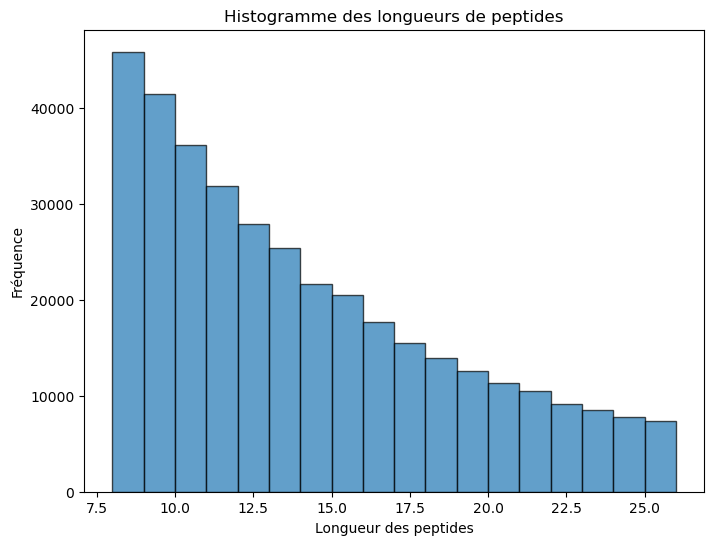

In [ ]:
peptide_lengths = data_human_unique_peptide["Peptide"].apply(len)

plt.figure(figsize=(8, 6))
plt.hist(peptide_lengths, bins=np.arange(peptide_lengths.min(), peptide_lengths.max() + 2, 1), edgecolor='black', alpha=0.7)
plt.xlabel("Longueur des peptides")
plt.ylabel("Fréquence")
plt.title("Histogramme des longueurs de peptides")
plt.show()
plt.close()

In [47]:
unique_peptide = data_human_unique_peptide["Peptide"]
filtering_self_training = unique_peptide.apply(len) <= max_len
unique_peptide = unique_peptide[filtering_self_training].reset_index(drop=True)
unique_peptide = unique_peptide.drop_duplicates(ignore_index = True)
unique_peptide

0                    MQLVQESEEK
1         QPCLPIWHEMVETGGSEGVVR
2           VPLLLSILGAILWVNRPWR
3                      SHPPPPEK
4               SVSLLRPPFSQLPSK
                  ...          
331077               ELNQYFELAK
331078       GSFLIWLLLCWNSWYHLR
331079          LCHGDSELTSGLLAT
331080                 SCQIEQVK
331081       YSVPDTGLFQHWEGSIPT
Name: Peptide, Length: 331082, dtype: object

In [ ]:
class PeptideBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, lstm_hidden_dim, output_dim, dropout_prob, num_layers):
        """
        Bidirectional LSTM-based classifier for peptide sequences.

        Args:
            vocab_size (int): Size of the vocabulary (number of amino acid + padding).
            embed_dim (int): Size of the embedding vectors.
            hidden_dim (int): Number of units in the fully connected hidden layer.
            lstm_hidden_dim (int): Number of hidden units in the BiLSTM.
            output_dim (int): Number of output classes (1 here).
            dropout_prob (float): Dropout rate applied after the first fully connected layer.
            num_layers (int): Number of LSTM layers.
        """
        super(PeptideBiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.bilstm = nn.LSTM(embed_dim, lstm_hidden_dim, num_layers=num_layers,
                              bidirectional=True, batch_first=True, dropout=dropout_prob)
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Embed input sequences
        embedded = self.embedding(x)  # (batch_size, max_seq_len, embed_dim)

        # BiLSTM encoding
        lstm_out, _ = self.bilstm(embedded)  # (batch_size, max_seq_len, 2 * lstm_hidden_dim)

        # Use the output of the last time step
        lstm_out_last = lstm_out[:, -1, :]  # (batch_size, 2 * lstm_hidden_dim)

        # Fully connected layers with dropout
        hidden = F.relu(self.fc1(lstm_out_last))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)  # (batch_size, output_dim)

        return output

# Functions

In [ ]:
def compute_best(history, best_history, model, best_model):
    """
    Compares the current model with the best model based on the 'pr_auc' or 'val_pr_auc' metric.

    Args:
        history (dict): Dictionary containing training and validation metrics of the current model.
        best_history (dict): Dictionary containing the best model's validation metrics so far.
        model (nn.Module): Current model.
        best_model (nn.Module): Previously saved best model.

    Returns:
        tuple:
            - best_model (nn.Module): Updated best model if the current model is better.
            - best_history (dict): Updated best history if the current model is better.
            - Better (bool): True if the current model outperformed the previous best.
    """
    
    def extract_metric_value(metric_data):
        """
        Extracts the relevant metric value from a scalar or sequence.
        Returns the last value if it is a sequence, otherwise returns the scalar value.
        """
        if isinstance(metric_data, (list, tuple)):
            return metric_data[-1]
        if hasattr(metric_data, 'ndim'):
            if metric_data.ndim == 0:
                return metric_data.item()
            return metric_data[-1]
        return metric_data

    # Select which metric to use
    if 'pr_auc' in history:
        metric = 'pr_auc'
    elif 'val_pr_auc' in history:
        metric = 'val_pr_auc'

    current_metric = extract_metric_value(history[metric])

    # Extract the metric from best_history if it exists
    best_metric_value = None
    if best_history is not None:
        if 'pr_auc' in best_history:
            best_metric_value = extract_metric_value(best_history['pr_auc'])
        elif 'val_pr_auc' in best_history:
            best_metric_value = extract_metric_value(best_history['val_pr_auc'])

    Better = False
    print(current_metric, best_metric_value)

    # Update best model if current model is better
    if best_history is None or current_metric > best_metric_value:
        best_model = model
        best_history = history
        Better = True

    return best_model, best_history, Better


def evaluate_bilstm_model(model, loader, histogram_path, plot=False):
    """
    Evaluates a trained BiLSTM model on a dataset and optionally plots a histogram of predicted probabilities.

    Args:
        model (nn.Module): Trained BiLSTM model.
        loader (DataLoader): DataLoader providing the test data (sequence, label, pseudo-label flag).
        histogram_path (str): Path to save the probability histogram (PNG file).
        plot (bool, optional): If True, generates and saves a histogram of predicted probabilities. Defaults to False.

    Returns:
        dict: Dictionary containing evaluation metrics:
              - 'accuracy': Classification accuracy.
              - 'precision': Precision score.
              - 'recall': Recall score.
              - 'f1': F1 score.
              - 'roc_auc': ROC AUC score.
              - 'pr_auc': Precision-Recall AUC score.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for sequences, labels, _ in loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets)

    # Convert probabilities to binary class predictions
    predicted_classes = (all_preds >= 0.5).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_targets, predicted_classes)
    precision = precision_score(all_targets, predicted_classes)
    recall = recall_score(all_targets, predicted_classes)
    f1 = f1_score(all_targets, predicted_classes)
    roc_auc = roc_auc_score(all_targets, all_preds)
    pr_auc = average_precision_score(all_targets, all_preds)

    # Optionally generate histogram of predicted probabilities
    if plot:
        plt.figure(figsize=(8, 6))
        plt.hist(all_preds, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
        plt.xlabel("Predicted probabilities")
        plt.ylabel("Frequency")
        plt.title("Histogram of predicted probabilities")
        plt.savefig(histogram_path, bbox_inches='tight')
        plt.close()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

def write_into_json(dict, filename):
    import json
    with open(filename, 'w') as f:
        json.dump(dict, f)

import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
VOCAB_SIZE = len(amino_acid_vocab) + 1
OUTPUT_DIM = 1
def find_BiLSTM_param(models_path="/content/drive/MyDrive/TFE/Models"):
    """
    Tries different hyperparameter combinations to load a BiLSTM model from a saved state dictionary.

    Args:
        models_path (str, optional): Path to the saved model state_dict file. 
                                     Defaults to "/content/drive/MyDrive/TFE/Models".

    Returns:
        tuple or None: Tuple (dropout, n_layers, hidden_size, embedding_size) if a model is successfully loaded,
                       otherwise None if no configuration works.
    """
    for dropout in [0.2, 0.3]:
        for n_layers in [1, 2, 3]:
            for hidden_size, embedding_size in [(64, 64), (128, 128)]:
                try:
                    model = PeptideBiLSTMClassifier(VOCAB_SIZE, embedding_size, 
                                            hidden_size, hidden_size, 
                                            OUTPUT_DIM, dropout, n_layers)
                    # Attempt to load model weights
                    model.load_state_dict(torch.load(models_path))
                    # If successful, return configuration
                    return dropout, n_layers, hidden_size, embedding_size
                except Exception as e:
                    print(
                        f"Erreur pour la config dropout={dropout}, "
                        f"n_layers={n_layers}, hidden_size={hidden_size}, "
                        f"embedding_size={embedding_size}."
                    )
    return None


# GridSearch on alpha values

In [ ]:
LEARNING_RATE = 3e-4
VOCAB_SIZE = len(amino_acid_vocab) + 1  # +1 for padding
EMBED_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
BATCH_SIZE = 32
LSTM_LAYERS = 2
LSTM_HIDDEN_DIM = 32
N_EPOCHS = 100
N_SPLITS = 5
DROPOUT = 0.3

count = 1
do_early_stopping = False
weighting = False
oversampling = True
FT = None
device = "cuda" if torch.cuda.is_available() else "cpu"
models_path = "/home/jwalraff/TFE/Models"
results_path = "/home/jwalraff/TFE/Results"
images_path = "/home/jwalraff/TFE/Images"

imbalanced_name_dict = {
    "Imbalance": {
        (False, False): "N",
        (True, False): "W",
        (False, True): "O"
    },
    "Early Stopping": {
        True: "ES",
        False: "NES"
    },
    "Transfer Learning": {
        True: "FT",
        False: "FE",
        None: "N"
    }
}

self_training_technique = {
    "fixed": ['70', '90', '95', '99'],
    "TopK": ['00', '01', '05', 'evo'],
    "optimal": ['pr', 'roc']
}

alphas = np.arange(10, 110, 10)

for tech, values in self_training_technique.items():
    for v in values:
        for soft in ['hard', 'soft']:
            kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
            
            fold_metrics = []
            
            for fold, (train_idx, test_idx) in enumerate(kf.split(df, df['quantotypic'])):
                print(f"Fold {fold+1} on 5 ; {tech} ; {v}")

                best_model = None
                best_res = None
                best_filename = None
                
                for filename in os.listdir(f"{models_path}/SelfTraining/BiLSTM"):
                    if f"fold{fold+1}" in filename and "double_loss" in filename and "praucstop" in filename and soft in filename:
                        if tech in filename and (tech != 'fixed' or 'TopK' not in filename):
                            value = filename.split("_")[-1].replace(".pth", "") if (tech == 'fixed') else filename.split("_")[-2]
                            if value == v or (tech=='optimal' and f"{tech}_{v}" in filename) or (v=='evo' and v in filename):
                                dropout, n_layers, hidden_size, embedding_size = find_BiLSTM_param(f"{models_path}/SelfTraining/BiLSTM/{filename}", verbose=False)
                                model = PeptideBiLSTMClassifier(VOCAB_SIZE, embedding_size, hidden_size, hidden_size, OUTPUT_DIM, dropout, n_layers)
                                model.load_state_dict(torch.load(f"{models_path}/SelfTraining/BiLSTM/{filename}"))
                                
                                tmp_train_df = df.iloc[train_idx]
                                test_df = df.iloc[test_idx]
                                
                                train_df, val_df = train_test_split(tmp_train_df, test_size = 0.2, stratify=tmp_train_df["quantotypic"], random_state=42)
                                
                                val_dataset = PeptideDataset(val_df['sequence'].values, val_df['quantotypic'].values, train_df["pseudo_label"].values, amino_acid_vocab, max_len)
                                validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

                                test_dataset = PeptideDataset(test_df['sequence'].values, test_df['quantotypic'].values, test_df["pseudo_label"].values, amino_acid_vocab, max_len)
                                test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
                                
                                res_val = evaluate_bilstm_model(model, validation_loader, amino_acid_vocab, max_len, f"{images_path}/SelfTraining/BiLSTM/BiLSTMOutputProbabilities_fold{fold+1}", plot=False)
                                
                                best_model, best_res, better = compute_best(res_val, best_res, model, best_model)
                                
                                if better:
                                    best_filename = filename

                res_test = evaluate_bilstm_model(model, test_loader, amino_acid_vocab, max_len, f"{images_path}/SelfTraining/BiLSTM/BiLSTMOutputProbabilities_fold{fold+1}", plot=False)
                
                fold_metrics.append({
                    "accuracy": res_test.get("accuracy"),
                    "precision": res_test.get("precision"),
                    "recall": res_test.get("recall"),
                    "f1": res_test.get("f1"),
                    "roc_auc": res_test.get("roc_auc"),
                    "pr_auc": res_test.get("pr_auc"),
                })
            
            summary = {
                "tech": tech,
                "v": v,
                "soft": soft,
                "metrics": {}
            }
            
            for metric in ["accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]:
                values = [m[metric] for m in fold_metrics if m[metric] is not None]
                summary["metrics"][f"{metric}_mean"] = np.mean(values) if values else None
                summary["metrics"][f"{metric}_std"] = np.std(values) if values else None

            save_fname = best_filename.replace(".pth", "").replace("_Maxiter5", "").replace("_cvfold5", "").replace("__", "_")
            write_into_json(summary, f"{results_path}/SelfTraining/BiLSTM/GridSearch/GridSearch_CVSummary_{save_fname}.json")

            print()
            print("MEAN +- STD PR AUC:", summary["metrics"]["pr_auc_mean"], "+-", summary["metrics"]["pr_auc_std"])
            print("\n=============================================================================================================")
            print("=============================================================================================================")
            print("=============================================================================================================\n")

Fold 1 on 5 ; fixed ; 70
0.4064130915524104 None
0.4036897800055695 0.4064130915524104
0.39836570593149545 0.4064130915524104
0.5002175577833472 0.4064130915524104
0.5156687675070027 0.5002175577833472
0.5124007936507936 0.5156687675070027
0.5124007936507936 0.5156687675070027
0.35695488721804514 0.5156687675070027
0.4314675577833472 0.5156687675070027
0.37723475355054303 0.5156687675070027
Fold 2 on 5 ; fixed ; 70
0.48749999999999993 None
0.4197524697524697 0.48749999999999993
0.34743867243867244 0.48749999999999993
0.39138888888888884 0.48749999999999993
0.2617948717948718 0.48749999999999993
0.41043823326432016 0.48749999999999993
0.505438542938543 0.48749999999999993
0.3667586841499885 0.505438542938543
0.36030982905982906 0.505438542938543
0.3386351872764916 0.505438542938543
Fold 3 on 5 ; fixed ; 70
0.6805555555555555 None
0.7027777777777777 0.6805555555555555
0.7313492063492063 0.7027777777777777
0.4907004830917874 0.7313492063492063
0.5414682539682539 0.7313492063492063
0.67575

In [37]:
results_path = "/home/jwalraff/TFE/Results"

better_res = 0
worse_res = 0
baseline = {"pr_auc_mean": 0.41902355956583304, "pr_auc_std": 0.15254380434371087, "roc_auc_mean": 0.5975155279503106, "roc_auc_std": 0.19345021879872196}

for filename in os.listdir(f"{results_path}/SelfTraining/BiLSTM"):
    if "CVSummary" in filename:        
        with open(f"{results_path}/SelfTraining/BiLSTM/{filename}", 'r') as f:
            data = json.load(f)
            
            if data["metrics"]["pr_auc_mean"] > baseline["pr_auc_mean"]:
                better_res += 1
            elif data["metrics"]["pr_auc_mean"] < baseline["pr_auc_mean"]:
                worse_res += 1


for filename in os.listdir(f"{results_path}/SelfTraining/BiLSTM/GridSearch"):
    if "CVSummary" in filename:
        with open(f"{results_path}/SelfTraining/BiLSTM/GridSearch/{filename}", 'r') as f:
            data = json.load(f)
            
            if data["metrics"]["pr_auc_mean"] > baseline["pr_auc_mean"]:
                better_res += 1
            elif data["metrics"]["pr_auc_mean"] < baseline["pr_auc_mean"]:
                worse_res += 1

print()
print(f"There are {better_res} better models compared to baseline")
print(f"There are {worse_res} worse models compared to baseline")        


There are 59 better models compared to baseline
There are 191 worse models compared to baseline


In [76]:
results_path = "/home/jwalraff/TFE/Results"

for filename in os.listdir(f"{results_path}/SelfTraining/BiLSTM/GridSearch"):
    print(filename)
    v = None
    if "TopK" in filename:
        if "evo" in filename:
            pl_method = "TopK_evo"
        else:
            v = filename.split("_")[-1].replace('.json', '')
            pl_method = "TopK_fixed"
    elif "fixed" in filename:
        v = filename.split("_")[-1].replace('.json', '')
        pl_method = "fixed"
    else:
        pl_method = "optimal_roc" if "roc" in filename else "optimal_pr"
        
    label_type = "hard_loss" if "hard" in filename else "soft_loss"
    dl = "double_loss"
    praucstop = "praucstop"
    
    with open(f"{results_path}/SelfTraining/BiLSTM/GridSearch/{filename}", 'r') as ff:
        baseline_data = json.load(ff)
    
    res_arrays = []
    is_better_than_baseline = []
    for f in os.listdir(f"{results_path}/SelfTraining/BiLSTM"):
        if label_type in f and praucstop in f and dl in f and "CVSummary" in f:
            if pl_method in f and (pl_method != 'fixed' or 'TopK' not in f):
                if v is not None and v in f.split("_")[-1]:
                    res_arrays.append(f)
                    with open(f"{results_path}/SelfTraining/BiLSTM/{f}", 'r') as fff:
                        data = json.load(fff)
                elif v is None:
                    res_arrays.append(res_arrays)
                    with open(f"{results_path}/SelfTraining/BiLSTM/{f}", 'r') as fff:
                        data = json.load(fff)
                else:
                    continue
                    
                if baseline_data["metrics"]["pr_auc_mean"] > data["metrics"]["pr_auc_mean"]:
                    is_better_than_baseline.append(True)
                else:
                    is_better_than_baseline.append(False)

    print()
    print(len(res_arrays))
    print()
    print(f"{pl_method} ; {v} ; {label_type} ; {dl} ; {praucstop} ; {is_better_than_baseline}")

fixed ; 70 ; hard_loss ; double_loss ; praucstop ; [False, False, False, False, False, False, False, False, False, False]
fixed ; 70 ; soft_loss ; double_loss ; praucstop ; [True, True, True, True, True, True, True, True, True, True]
fixed ; 90 ; hard_loss ; double_loss ; praucstop ; [False, False, False, False, False, False, False, False, False, False]
fixed ; 90 ; soft_loss ; double_loss ; praucstop ; [True, True, False, False, False, False, False, False, False, False]
fixed ; 95 ; hard_loss ; double_loss ; praucstop ; [False, False, False, False, False, False, False, False, False, False]
fixed ; 95 ; soft_loss ; double_loss ; praucstop ; [True, True, True, True, True, True, True, True, True, True]
fixed ; 99 ; hard_loss ; double_loss ; praucstop ; [False, False, False, False, False, False, False, False, False, False]
fixed ; 99 ; soft_loss ; double_loss ; praucstop ; [True, True, True, True, True, True, True, True, True, True]
TopK_fixed ; 00 ; hard_loss ; double_loss ; praucstop ; 